In [12]:
# !pip install fbprophet
#pip install pystan

In [54]:
import numpy as np
import pandas as pd
import datetime
from numpy import concatenate
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [14]:
from __future__ import division

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
from matplotlib import pyplot as plt

In [15]:
import seaborn as sns
from fbprophet import Prophet
pd.plotting.register_matplotlib_converters()

### Set 'predict_hourly' True for hourly forecast or False for complete 1 day forcast

In [16]:
predict_hourly = True

In [9]:
liquidity=pd.read_excel('Anon_EU_USD_Mar_2017.xlsx')

In [10]:
liquidity_copy = liquidity.copy()

In [17]:
liquidity.head()

,Montran Reference,New-Acct,trn_date,trn_mtype,amount,New-ABA,trn_type,Flexcube_timestamp
0,70303P00213000,acct24,2017-03-03 06:01:17,C,46037.20,NaN,CHIPS Incoming,03-MAR-17 06.03.04.510491 AM
1,70303P00213100,acct52,2017-03-03 06:01:17,C,42705.60,NaN,CHIPS Incoming,03-MAR-17 06.03.04.970025 AM
2,70303P00213200,acct52,2017-03-03 06:01:18,C,32832.00,NaN,CHIPS Incoming,03-MAR-17 06.03.05.384726 AM
3,70303P00213300,acct24,2017-03-03 06:01:20,C,73771261.21,NaN,CHIPS Incoming,03-MAR-17 06.03.05.823524 AM
4,70303P00213400,acct8,2017-03-03 06:01:21,C,656723.55,NaN,CHIPS Incoming,03-MAR-17 06.15.03.138219 AM


In [18]:
liquidity.tail()

,Montran Reference,New-Acct,trn_date,trn_mtype,amount,New-ABA,trn_type,Flexcube_timestamp
309531,70331U013181IN,acct383,2017-03-31 17:59:05,D,242269.68,NaN,BOOK TRANSFER,31-MAR-17 05.59.53.892141 PM
309532,70331U013182IN,acct149,2017-03-31 18:00:05,C,93430.55,NaN,BOOK TRANSFER,31-MAR-17 06.00.54.500733 PM
309533,70331U013182IN,acct94,2017-03-31 18:00:05,D,93430.55,NaN,BOOK TRANSFER,31-MAR-17 06.00.54.293635 PM
309534,70331U013183IN,acct279,2017-03-31 18:03:07,D,93430.55,NaN,BOOK TRANSFER,31-MAR-17 06.03.53.966380 PM
309535,70331U013183IN,acct94,2017-03-31 18:03:07,C,93430.55,NaN,BOOK TRANSFER,31-MAR-17 06.03.54.163341 PM


In [19]:
liquidity.shape

(309536, 8)

In [20]:
liquidity.columns

Index(['Montran Reference', 'New-Acct', 'trn_date', 'trn_mtype', 'amount',
       'New-ABA', 'trn_type', 'Flexcube_timestamp'],
      dtype='object')

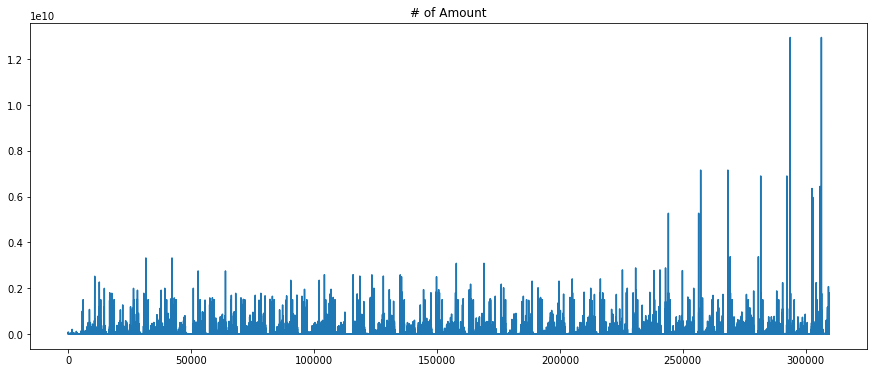

In [21]:
plt.figure(figsize=(15,6))
liquidity.amount.plot(title='# of Amount')

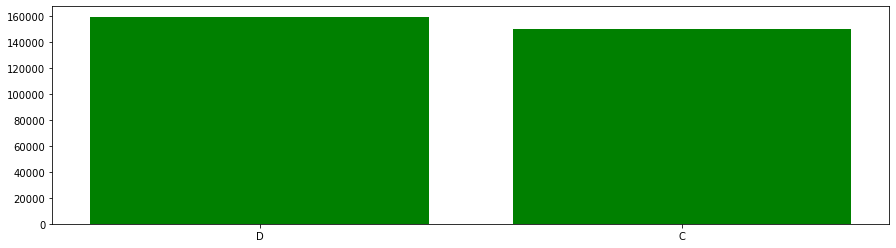

In [22]:
plt.figure(figsize=(15,4))
top_ten=liquidity.groupby(['trn_mtype']).count().sort_values(by='amount',ascending=False).head(10)
plt.bar(x=top_ten.index,height=top_ten['amount'],color='green')
plt.show()

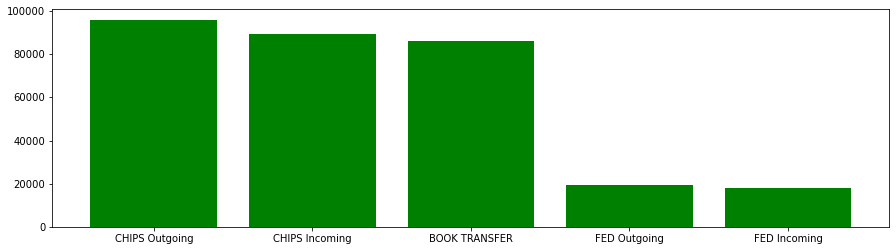

In [23]:
plt.figure(figsize=(15,4))
top_ten_1=liquidity.groupby(['trn_type']).count().sort_values(by='amount',ascending=False).head(10)
plt.bar(x=top_ten_1.index,height=top_ten_1['amount'],color='green')
plt.show()

###  Preprocess

In [24]:
def preprocessit(data_tmp, feature_list, split_time= False, dropnan=True):
    
    data = data_tmp.copy()
    if dropnan:
        data.dropna(how='all', inplace=True)
    
    if len(feature_list) != 0:
        data.drop(feature_list,axis=1,inplace=True)
    
    data.rename(columns={'Flexcube_timestamp' : 'date'}, inplace=True)
    data['date']= pd.to_datetime(data['date'], format='%d-%b-%y  %I.%M.%S.%f %p')     
    
    if split_time:
        data.rename(columns={'date' : 'dat'}, inplace=True)
        data['date'] = pd.to_datetime(data['dat']).dt.date
        data['date'] = pd.to_datetime(data['date'])
        data['Time'] = pd.to_datetime(data['dat']).dt.time
        data.drop(columns=['dat'], inplace=True)    
    
    data.set_index('date', inplace=True)
    
    return data
    

In [25]:
drop_list = ['Montran Reference', 'New-Acct', 'trn_date', 'New-ABA', 'trn_type']
df_liquidity = preprocessit(liquidity, drop_list)
df_liquidity.head()

,trn_mtype,amount
date,,
2017-03-03 06:03:04.510491,C,46037.20
2017-03-03 06:03:04.970025,C,42705.60
2017-03-03 06:03:05.384726,C,32832.00
2017-03-03 06:03:05.823524,C,73771261.21
2017-03-03 06:15:03.138219,C,656723.55


In [26]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [27]:
X, y = create_features(df_liquidity, label='amount')

features_and_target = pd.concat([X, y], axis=1)


In [28]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,amount
date,,,,,,,,,
2017-03-03 06:03:04.510491,6,4,1,3,2017,62,3,9,46037.20
2017-03-03 06:03:04.970025,6,4,1,3,2017,62,3,9,42705.60
2017-03-03 06:03:05.384726,6,4,1,3,2017,62,3,9,32832.00
2017-03-03 06:03:05.823524,6,4,1,3,2017,62,3,9,73771261.21
2017-03-03 06:15:03.138219,6,4,1,3,2017,62,3,9,656723.55


In [29]:
features_and_target.shape

(309536, 9)

In [30]:
features_and_target.tail()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,amount
date,,,,,,,,,
2017-03-31 17:59:53.892141,17,4,1,3,2017,90,31,13,242269.68
2017-03-31 18:00:54.500733,18,4,1,3,2017,90,31,13,93430.55
2017-03-31 18:00:54.293635,18,4,1,3,2017,90,31,13,93430.55
2017-03-31 18:03:53.966380,18,4,1,3,2017,90,31,13,93430.55
2017-03-31 18:03:54.163341,18,4,1,3,2017,90,31,13,93430.55


### Plotting the Features to see trends

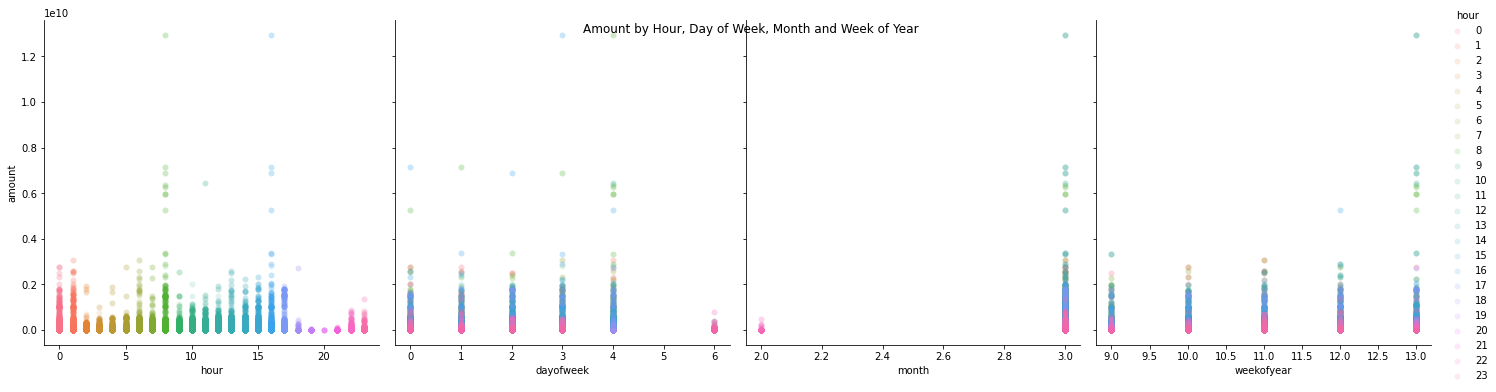

In [31]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'month','weekofyear'],
             y_vars='amount',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Amount by Hour, Day of Week, Month and Week of Year')
plt.show()

### Train/Test Split

#### select only amount as feautre

In [32]:
df_liquidity1 = features_and_target[['amount']]
df_liquidity1.reset_index(inplace=True)
df_liquidity1.head()

,date,amount
0,2017-03-03 06:03:04.510491,46037.20
1,2017-03-03 06:03:04.970025,42705.60
2,2017-03-03 06:03:05.384726,32832.00
3,2017-03-03 06:03:05.823524,73771261.21
4,2017-03-03 06:15:03.138219,656723.55


In [34]:
df_liquidity.head()

,trn_mtype,amount
date,,
2017-03-03 06:03:04.510491,C,46037.20
2017-03-03 06:03:04.970025,C,42705.60
2017-03-03 06:03:05.384726,C,32832.00
2017-03-03 06:03:05.823524,C,73771261.21
2017-03-03 06:15:03.138219,C,656723.55


In [35]:
df_liquidity1 = df_liquidity1.resample('H', on='date').mean()
df_liquidity1.head()

,amount
date,
2017-02-28 22:00:00,3.204491e+06
2017-02-28 23:00:00,4.321000e+05
2017-03-01 00:00:00,9.798370e+06
2017-03-01 01:00:00,9.118884e+06
2017-03-01 02:00:00,3.338729e+06


In [36]:
# if predict_hourly:
#     df_liquidity1 = df_liquidity.resample('H', on='date').mean()
# else :
#     df_liquidity1 = df_liquidity.resample('D', on='date').mean()
# df_liquidity1.head()

#### Check for NA values

In [37]:
print(df_liquidity1.shape)
df_liquidity1.isna().sum()

(741, 1)


amount    239
dtype: int64

#### Fill NA

In [38]:
df_liquidity1.fillna(0,inplace=True)
df_liquidity1.isna().sum()

amount    0
dtype: int64

In [39]:
liquidity.Flexcube_timestamp.max()

'31-MAR-17 12.59.56.261792 PM'

df_liquidity1.set_index('date', inplace=True)
df_liquidity1.head()

In [40]:
split_date = '2017-03-31'
liq_train = df_liquidity1.loc[df_liquidity1.index <= split_date].copy()
liq_test = df_liquidity1.loc[df_liquidity1.index > split_date].copy()

In [41]:
liq_train.shape

(723, 1)

In [42]:
liq_test.shape

(18, 1)

In [43]:
liq_train.head()

,amount
date,
2017-02-28 22:00:00,3.204491e+06
2017-02-28 23:00:00,4.321000e+05
2017-03-01 00:00:00,9.798370e+06
2017-03-01 01:00:00,9.118884e+06
2017-03-01 02:00:00,3.338729e+06


In [44]:
liq_test.tail()

,amount
date,
2017-03-31 14:00:00,2.898737e+07
2017-03-31 15:00:00,1.920516e+07
2017-03-31 16:00:00,2.651569e+07
2017-03-31 17:00:00,2.557517e+07
2017-03-31 18:00:00,7.238676e+07


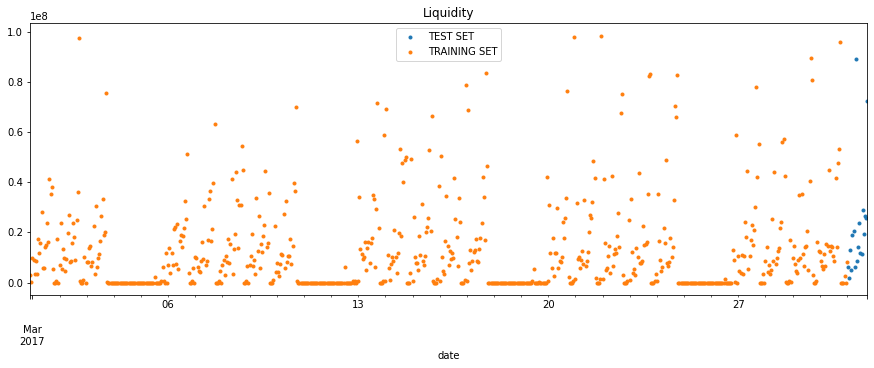

In [45]:
# Plot train and test so you can see where we have split
liq_test \
    .rename(columns={'amount': 'TEST SET'}) \
    .join(liq_train.rename(columns={'amount': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='Liquidity', style='.')
plt.show()

### Prophet Model

In [46]:
# Format data for prophet model using ds and y
liq_train.reset_index() \
    .rename(columns={'date':'ds',
                     'amount':'y'}).head()

,ds,y
0,2017-02-28 22:00:00,3.204491e+06
1,2017-02-28 23:00:00,4.321000e+05
2,2017-03-01 00:00:00,9.798370e+06
3,2017-03-01 01:00:00,9.118884e+06
4,2017-03-01 02:00:00,3.338729e+06


In [47]:
# Setup and train model and fit
model = Prophet(seasonality_prior_scale=0.1)
model.fit(liq_train.reset_index() \
    .rename(columns={'date':'ds',
                     'amount':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


### Prediction

In [48]:
if predict_hourly :
    future = model.make_future_dataframe(periods=1*24, freq='H')
else:
    future = model.make_future_dataframe(periods=1)
liq_test_fcst = model.predict(future)

In [49]:
print(liq_test_fcst.shape)
liq_test_fcst.head()

(747, 19)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-02-28 22:00:00,1.010550e+07,-1.037242e+07,2.537922e+07,1.010550e+07,1.010550e+07,-2.775372e+06,-2.775372e+06,-2.775372e+06,-7.431047e+06,-7.431047e+06,-7.431047e+06,4.655675e+06,4.655675e+06,4.655675e+06,0.0,0.0,0.0,7.330125e+06
1,2017-02-28 23:00:00,1.011162e+07,-3.978536e+06,3.166515e+07,1.011162e+07,1.011162e+07,5.047528e+06,5.047528e+06,5.047528e+06,3.530855e+05,3.530855e+05,3.530855e+05,4.694443e+06,4.694443e+06,4.694443e+06,0.0,0.0,0.0,1.515915e+07
2,2017-03-01 00:00:00,1.011774e+07,-1.657552e+05,3.648722e+07,1.011774e+07,1.011774e+07,7.842651e+06,7.842651e+06,7.842651e+06,3.109985e+06,3.109985e+06,3.109985e+06,4.732667e+06,4.732667e+06,4.732667e+06,0.0,0.0,0.0,1.796039e+07
3,2017-03-01 01:00:00,1.012386e+07,-3.643676e+06,3.300488e+07,1.012386e+07,1.012386e+07,4.558868e+06,4.558868e+06,4.558868e+06,-2.102581e+05,-2.102581e+05,-2.102581e+05,4.769126e+06,4.769126e+06,4.769126e+06,0.0,0.0,0.0,1.468273e+07
4,2017-03-01 02:00:00,1.012998e+07,-9.342073e+06,2.724412e+07,1.012998e+07,1.012998e+07,-9.237343e+05,-9.237343e+05,-9.237343e+05,-5.726381e+06,-5.726381e+06,-5.726381e+06,4.802646e+06,4.802646e+06,4.802646e+06,0.0,0.0,0.0,9.206247e+06


In [50]:
liq_test_fcst.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
742,2017-03-31 20:00:00,1.453247e+07,-1.757236e+07,1.789766e+07,1.453237e+07,1.453259e+07,-1.400481e+07,-1.400481e+07,-1.400481e+07,-1.392339e+07,-1.392339e+07,-1.392339e+07,-8.142769e+04,-8.142769e+04,-8.142769e+04,0.0,0.0,0.0,5.276587e+05
743,2017-03-31 21:00:00,1.453832e+07,-1.814399e+07,1.788384e+07,1.453820e+07,1.453845e+07,-1.507965e+07,-1.507965e+07,-1.507965e+07,-1.431056e+07,-1.431056e+07,-1.431056e+07,-7.690964e+05,-7.690964e+05,-7.690964e+05,0.0,0.0,0.0,-5.413393e+05
744,2017-03-31 22:00:00,1.454416e+07,-1.430625e+07,2.329412e+07,1.454403e+07,1.454431e+07,-8.916913e+06,-8.916913e+06,-8.916913e+06,-7.431047e+06,-7.431047e+06,-7.431047e+06,-1.485866e+06,-1.485866e+06,-1.485866e+06,0.0,0.0,0.0,5.627244e+06
745,2017-03-31 23:00:00,1.455000e+07,-5.235288e+06,3.134136e+07,1.454987e+07,1.455017e+07,-1.875009e+06,-1.875009e+06,-1.875009e+06,3.530855e+05,3.530855e+05,3.530855e+05,-2.228094e+06,-2.228094e+06,-2.228094e+06,0.0,0.0,0.0,1.267499e+07
746,2017-04-01 00:00:00,1.455584e+07,-4.122364e+06,3.265776e+07,1.455569e+07,1.455602e+07,1.181814e+05,1.181814e+05,1.181814e+05,3.109985e+06,3.109985e+06,3.109985e+06,-2.991803e+06,-2.991803e+06,-2.991803e+06,0.0,0.0,0.0,1.467402e+07


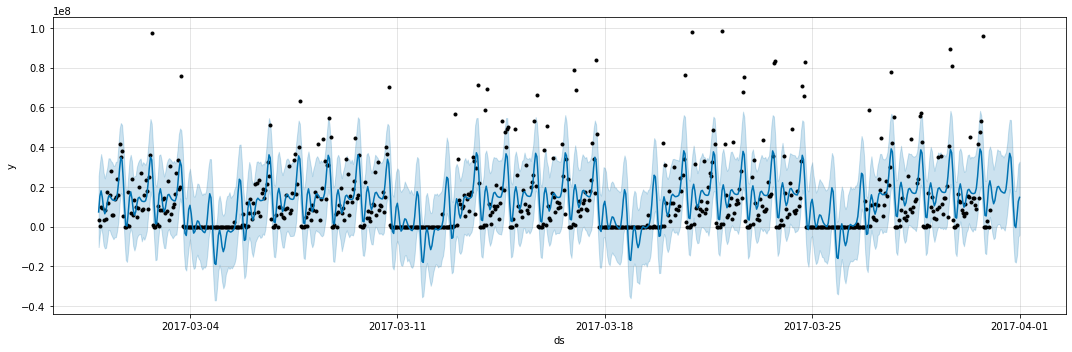

In [51]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(liq_test_fcst,
                 ax=ax)
plt.show()

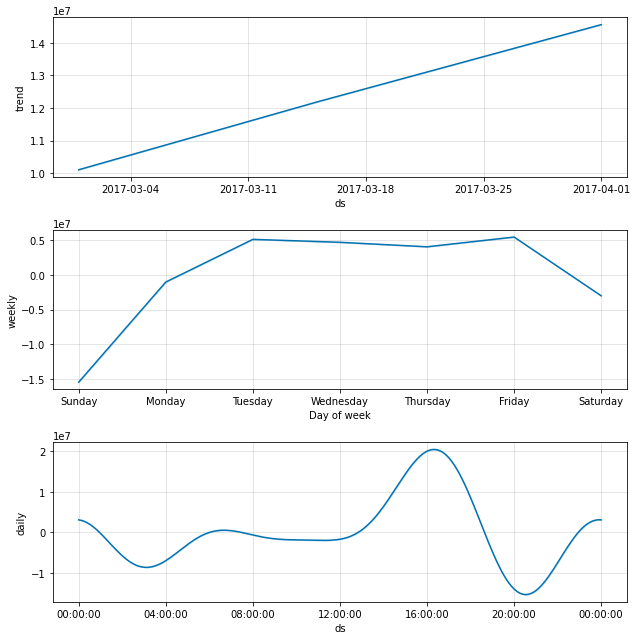

In [52]:
# Plot the components of the model
fig = model.plot_components(liq_test_fcst)

liq_test_fcst.to_csv("24HourForecast_NoResampleModel.csv")

In [57]:
liq_test_fcst['yhat'].shape
liq_test['amount'].shape

(18,)

In [59]:
##train error
mean_squared_error(y_true=liq_train['amount'],
                   y_pred=liq_test_fcst['yhat'][0:723])

202082778828318.06

In [62]:
mean_absolute_error(y_true=liq_train['amount'],
                   y_pred=liq_test_fcst['yhat'][0:723])

9581060.318764191

In [60]:
##test error
mean_squared_error(y_true=liq_test['amount'],
                   y_pred=liq_test_fcst['yhat'][723:741])

470015174196921.5

In [61]:
mean_absolute_error(y_true=liq_test['amount'],
                   y_pred=liq_test_fcst['yhat'][723:741])

13281466.271986295

#### MAPE

In [63]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [65]:
##test error
mean_absolute_percentage_error(y_true=liq_test['amount'],
                   y_pred=liq_test_fcst['yhat'][723:741])

101.52648612292532

In [67]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]

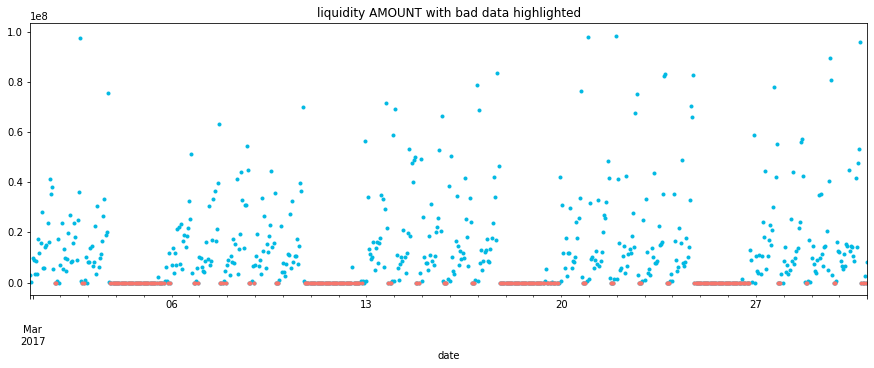

In [68]:
ax = liq_train.plot(style='.',
                     figsize=(15,5),
                     color=color_pal[5],
                     title='liquidity AMOUNT with bad data highlighted',
                     xlim=('01-01-2012','01-01-2013')
                    )
liq_train.query('amount < 19000').plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[0],
                                             ax=ax)
ax.legend().set_visible(False)
plt.show()

In [71]:
liq_train.describe()

,amount
count,7.230000e+02
mean,1.259080e+07
std,1.802086e+07
min,0.000000e+00
25%,0.000000e+00
50%,6.538924e+06
75%,1.653049e+07
max,9.851186e+07
